# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci697l.github.io/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [5]:
import random
import numpy as np
from asgn1.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **asgn1/classifiers/softmax.py**. 


In [7]:
# First implement the naive softmax loss function with nested loops.
# Open the file asgn1/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from asgn1.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.340780
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Before implementing our loss function, average probability of each example to belong to one of the 10 classes would be ~0.1.*


In [8]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from asgn1.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.254569 analytic: 1.254569, relative error: 7.090891e-08
numerical: 0.662603 analytic: 0.662603, relative error: 6.126683e-08
numerical: 0.609487 analytic: 0.609487, relative error: 8.072719e-08
numerical: -0.154994 analytic: -0.154994, relative error: 1.717565e-07
numerical: 0.574605 analytic: 0.574605, relative error: 9.183856e-08
numerical: 0.437746 analytic: 0.437746, relative error: 9.774721e-08
numerical: -0.175480 analytic: -0.175480, relative error: 1.271734e-07
numerical: 1.050321 analytic: 1.050321, relative error: 9.671437e-09
numerical: -2.110943 analytic: -2.110943, relative error: 5.167025e-08
numerical: -1.409158 analytic: -1.409158, relative error: 4.943534e-08
numerical: -1.333766 analytic: -1.348038, relative error: 5.321881e-03
numerical: -0.648415 analytic: -0.644089, relative error: 3.346553e-03
numerical: 0.113151 analytic: 0.120181, relative error: 3.012939e-02
numerical: -1.459849 analytic: -1.460336, relative error: 1.667801e-04
numerical: -3.853230

In [54]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from asgn1.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.317848e+00 computed in 0.180739s
vectorized loss: 2.317848e+00 computed in 0.005567s
Loss difference: 0.000000
Gradient difference: 0.000000


In [60]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from asgn1.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [5e4, 1e8]
learning_rates = [1e-7, 1e-6]
regularization_strengths = [7e3, 5e2]
#learning_rates = np.logspace(-10, 10, 10)
#regularization_strengths = np.logspace(-3, 6, 10)
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=4000, batch_size= 200, verbose=True)
        
        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train_pred == y_val)
        
        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val_pred == y_val)
        
        if(validation_accuracy > best_val):
            best_val = validation_accuracy
            best_softmax = softmax
        
        results[(lr, rs)] = (training_accuracy, validation_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 4000: loss 218.555646
iteration 100 / 4000: loss 188.444004
iteration 200 / 4000: loss 163.579203
iteration 300 / 4000: loss 142.087899
iteration 400 / 4000: loss 123.394416
iteration 500 / 4000: loss 107.349562
iteration 600 / 4000: loss 93.268110
iteration 700 / 4000: loss 81.267954
iteration 800 / 4000: loss 70.663963
iteration 900 / 4000: loss 61.605637
iteration 1000 / 4000: loss 53.783036
iteration 1100 / 4000: loss 46.967737
iteration 1200 / 4000: loss 41.084176
iteration 1300 / 4000: loss 35.877528
iteration 1400 / 4000: loss 31.340206
iteration 1500 / 4000: loss 27.556685
iteration 1600 / 4000: loss 24.246965
iteration 1700 / 4000: loss 21.242570
iteration 1800 / 4000: loss 18.716567
iteration 1900 / 4000: loss 16.638867
iteration 2000 / 4000: loss 14.608235
iteration 2100 / 4000: loss 13.008516
iteration 2200 / 4000: loss 11.466071
iteration 2300 / 4000: loss 10.252187
iteration 2400 / 4000: loss 9.115287
iteration 2500 / 4000: loss 8.282985
iteration 2600 / 400

/Users/abhaydoke/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


iteration 0 / 4000: loss 22.258189
iteration 100 / 4000: loss 18.910219
iteration 200 / 4000: loss 18.252406
iteration 300 / 4000: loss 17.858228
iteration 400 / 4000: loss 17.522638
iteration 500 / 4000: loss 17.556829
iteration 600 / 4000: loss 17.437485
iteration 700 / 4000: loss 16.789430
iteration 800 / 4000: loss 16.343705
iteration 900 / 4000: loss 16.504268
iteration 1000 / 4000: loss 16.597722
iteration 1100 / 4000: loss 16.002086
iteration 1200 / 4000: loss 16.032263
iteration 1300 / 4000: loss 15.789166
iteration 1400 / 4000: loss 15.571211
iteration 1500 / 4000: loss 15.444673
iteration 1600 / 4000: loss 15.177638
iteration 1700 / 4000: loss 14.754436
iteration 1800 / 4000: loss 14.876637
iteration 1900 / 4000: loss 14.675944
iteration 2000 / 4000: loss 14.377810
iteration 2100 / 4000: loss 14.448950
iteration 2200 / 4000: loss 14.263500
iteration 2300 / 4000: loss 14.233646
iteration 2400 / 4000: loss 13.997676
iteration 2500 / 4000: loss 13.879928
iteration 2600 / 4000: l

In [61]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.401000


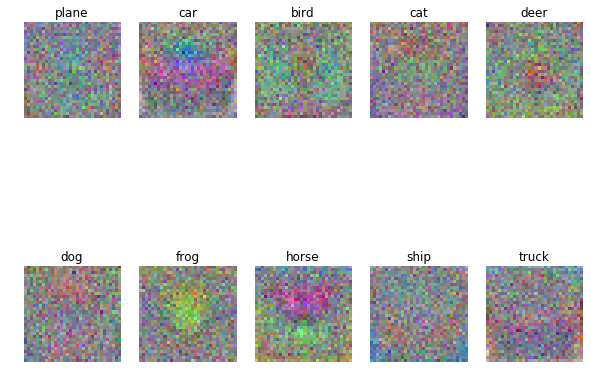

In [62]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])